<a href="https://colab.research.google.com/github/td-iceman/Tarandeep-Projects/blob/main/Tensorflow/cifar10/cifar10_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ResNet model for CIFAR-10 image recognition

<br />
This code shows an implementation of the residual network block to create a 10 resnet block CNN for performing CIFAR-10 image recognition task. This notebook was run using Google collab.
<br />

In [13]:
#@title Default title text
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10

tf.version.VERSION

'2.8.2'

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)


In [4]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

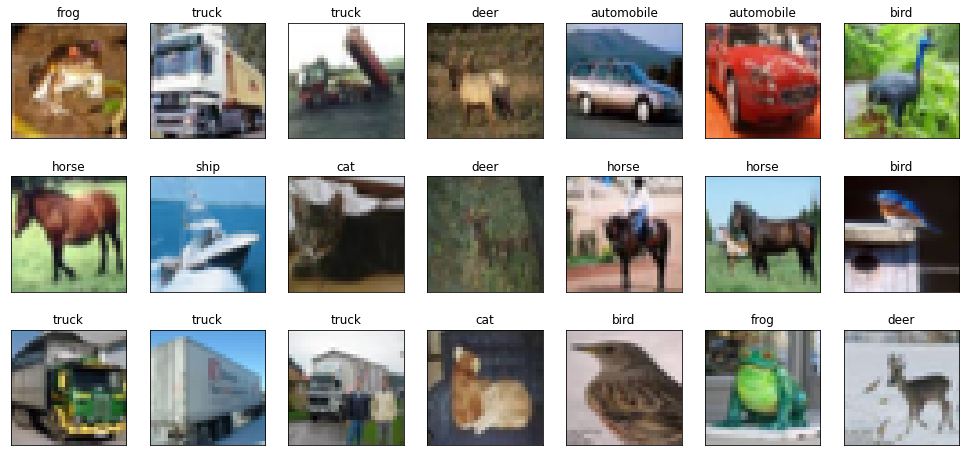

In [5]:
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(17, 8))
index = 0
for i in range(3):
    for j in range(7):
        axes[i,j].set_title(labels[y_train[index][0]])
        axes[i,j].imshow(X_train[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

In [6]:
## -- resnet block function -- 
## -- weights->BN->relu->weights->BN-->Add->relu --

def resnet_block(in_layer, kernel):
    filters = in_layer.shape[3]
    a = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel,
        activation = None,
        padding='same'
    )(in_layer)
    b = tf.keras.layers.BatchNormalization()(a)
    c = tf.keras.layers.Activation('relu')(b)

    d = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel,
        activation = None,
        padding='same'
    )(c)
    e = tf.keras.layers.BatchNormalization()(d)
    f = tf.keras.layers.Add()([e, in_layer])
    g = tf.keras.layers.Activation('relu')(f)
    return g   

In [7]:
in_put = tf.keras.Input(shape=(32,32,3), name='input_layer')

## -- RES-SUPERBLOCK 1 --
conv1 = tf.keras.layers.Conv2D( name='plain_conv1',
        filters=32,
        kernel_size=3,
        activation = 'relu',
        padding='same'
)(in_put)
res1 = resnet_block(conv1, kernel=3)
res2 = resnet_block(res1, kernel=3)
res3 = resnet_block(res2, kernel=3)
# -- max pool 1 --
pool1 = tf.keras.layers.MaxPool2D( name='pool1',
    pool_size=(2, 2),
)(res3)


## -- RES-SUPERBLOCK 2 --
conv3 = tf.keras.layers.Conv2D( name='plain_conv3',
        filters=64,
        kernel_size=3,
        activation = 'relu',
        padding='same'
)(pool1)
res4 = resnet_block(conv3, kernel=3)
res5 = resnet_block(res4, kernel=3)
res6 = resnet_block(res5, kernel=3)
# -- max pool 2 --
pool2 = tf.keras.layers.MaxPool2D( name='pool2',
    pool_size=(2, 2),
)(res6)


## -- RES-SUPERBLOCK 3 --
conv5 = tf.keras.layers.Conv2D( name='plain_conv5',
        filters=128,
        kernel_size=3,
        activation = 'relu',
        padding='same'
)(pool2)
res7 = resnet_block(conv5, kernel=3)
res8 = resnet_block(res7, kernel=3)
res9 = resnet_block(res8, kernel=3)
res10 = resnet_block(res9, kernel=3)
pool3 = tf.keras.layers.MaxPool2D( name='pool3',
    pool_size=(2, 2),
)(res9)


flat1 = tf.keras.layers.Flatten()(pool3)
dense1 = tf.keras.layers.Dense(120, activation='relu', name='dense1')(flat1)
output = tf.keras.layers.Dense(10, activation='softmax')(dense1)

model_res = tf.keras.Model(in_put, output)

In [8]:
model_res.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 plain_conv1 (Conv2D)           (None, 32, 32, 32)   896         ['input_layer[0][0]']            
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   9248        ['plain_conv1[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                   

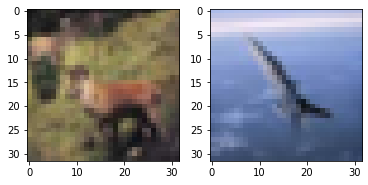

In [9]:
## -- creating dataset using TF Dataset API --

BATCH_SIZE = 100
dataset = tf.data.Dataset.from_tensor_slices(((X_train/255.).reshape(-1,32,32,3), 
                                              to_categorical(y_train.reshape(-1,1))))
dataset = dataset.shuffle(len(X_train)).batch(BATCH_SIZE)

testset = tf.data.Dataset.from_tensor_slices(((X_test/255.).reshape(-1,32,32,3), 
                                              to_categorical(y_test.reshape(-1,1))))
testset = testset.shuffle(len(X_test)).batch(BATCH_SIZE)

# -- plotting two examples from the shuffled dataset
fig, axes = plt.subplots(ncols=2, nrows=1)
for i,m in enumerate(dataset.take(2)):
    axes[i].imshow(m[0][0])
plt.show()

In [10]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=150,
    decay_rate=0.95)

model_res.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='CategoricalCrossentropy', metrics=['accuracy'])

history = model_res.fit(dataset, epochs=20, validation_data=testset)

Epoch 1/20
500/500 [==============================] - 37s 47ms/step - loss: 1.7147 - accuracy: 0.3968 - val_loss: 2.7717 - val_accuracy: 0.2715
Epoch 2/20
500/500 [==============================] - 23s 46ms/step - loss: 0.9912 - accuracy: 0.6453 - val_loss: 0.9589 - val_accuracy: 0.6593
Epoch 3/20
500/500 [==============================] - 24s 47ms/step - loss: 0.7529 - accuracy: 0.7322 - val_loss: 1.2890 - val_accuracy: 0.5932
Epoch 4/20
500/500 [==============================] - 23s 47ms/step - loss: 0.6195 - accuracy: 0.7814 - val_loss: 0.7127 - val_accuracy: 0.7553
Epoch 5/20
500/500 [==============================] - 23s 47ms/step - loss: 0.5181 - accuracy: 0.8167 - val_loss: 0.8722 - val_accuracy: 0.7226
Epoch 6/20
500/500 [==============================] - 24s 47ms/step - loss: 0.4269 - accuracy: 0.8491 - val_loss: 0.7979 - val_accuracy: 0.7470
Epoch 7/20
500/500 [==============================] - 24s 47ms/step - loss: 0.3462 - accuracy: 0.8775 - val_loss: 0.5937 - val_accuracy:

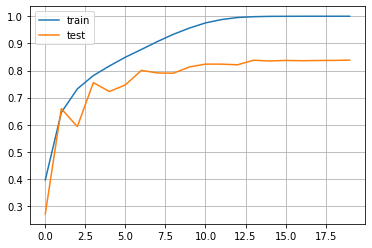

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [12]:
[loss, acc] = model_res.evaluate(testset)
print(f'Accuracy on test data: {round(acc*100,1)} %')

100/100 [==============================] - 2s 15ms/step - loss: 0.8159 - accuracy: 0.8383
Accuracy on test data: 83.8 %


<br />
The resnet model with 10 residual network blocks performs with an accuracy of about 84% on the cifar10 dataset.

<br />